In [4]:
# Laurent LEQUIEVRE
# Research Engineer, CNRS (France)
# Institut Pascal UMR6602
# laurent.lequievre@uca.fr

# https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda

# -> https://github.com/markusbuchholz/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py
# -> https://markus-x-buchholz.medium.com/deep-reinforcement-learning-introduction-deep-q-network-dqn-algorithm-fb74bf4d6862


# https://github.com/deligentfool/dqn_zoo/blob/master/DDQN/ddqn.py


In [13]:
import numpy as np
import random 
from collections import namedtuple, deque 
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = {}".format(device))

device = cuda:0


In [15]:
import gym
from gym.envs.registration import register

In [16]:
# If you got that error after a registration :
# Error: Cannot re-register id: FrozenLakeNotSlippery-v0
# So you need to delete an env registered

env_dict = gym.envs.registration.registry.env_specs.copy()

for env in env_dict:
    if 'FrozenLakeNotSlippery-v0' in env:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]


register(
   id="FrozenLakeNotSlippery-v0",
   entry_point='gym.envs.toy_text:FrozenLakeEnv',
   kwargs={'map_name': '8x8', 'is_slippery': False},
)

env = gym.make("FrozenLakeNotSlippery-v0")
print('Number of states: ', env.observation_space.n)
print('Number of actions: ', env.action_space.n)

Remove FrozenLakeNotSlippery-v0 from registry
Number of states:  64
Number of actions:  4


In [17]:
def get_index_of_holes(an_env):
    
    env_list = [[c.decode("utf-8") for c in line] for line in an_env.desc]
    index_holes = []
    
    size = np.int64(np.sqrt(an_env.observation_space.n))
    
    for i in range(size):
        for j in range(size):
            c = env_list[i][j]
            if (c == 'H'):
                index_holes.append(i*size+j)
    return index_holes


l = get_index_of_holes(env)

print("Indexes of Holes = {}".format(l))

Indexes of Holes = [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]


In [18]:
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [19]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.observation_space_size = state_size
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        obs_emb = F.one_hot(state.long(), num_classes=self.observation_space_size).squeeze()
        x = F.relu(self.fc1(obs_emb.float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [281]:
def take_action(action, env, indexes_of_holes):
    new_state, reward, done, info = env.step(action)
    index_of_goal = env.observation_space.n - 1
    # Reward function
    # if new_state is a Hole
    #if new_state in [5, 7, 11, 12]:
    if new_state in indexes_of_holes:
        reward = -1
    # else if new_state is the Goal (Final State)
    elif new_state == index_of_goal:
        reward = 1
    # else penalize research
    else:
        reward = -0.01
    return new_state, reward, done, info

In [282]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            
        """
        self.state_size = state_size
        self.action_size = action_size
        

        # Q-Network
        self.qnetwork_local = QNetwork(self.state_size, self.action_size)
        self.qnetwork_target = QNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

        
    def choose_action(self, s):
        if (np.random.rand(1) < 0.1): 
            #print("sample action !")
            #return self.env.action_space.sample()
            return random.choice(np.arange(self.action_size))
        else:
            agent_out = self.qnetwork_local(torch.tensor(s)).detach()
            #print(agent_out)
            index_max = np.argmax(agent_out)
            #print("index max = {}".format(index_max))
            #print("torch max action !")
            return index_max.item()    
        
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
agent = Agent(state_size=env.observation_space.n, action_size=env.action_space.n)

Episode 100	Average Score: -1.97
Episode 200	Average Score: -1.98
Episode 300	Average Score: -1.76
Episode 400	Average Score: -1.61
Episode 500	Average Score: -1.79
Episode 600	Average Score: -1.86
Episode 700	Average Score: -1.79
Episode 800	Average Score: -1.90
Episode 900	Average Score: -1.71
Episode 1000	Average Score: -1.87
Episode 1100	Average Score: -1.85
Episode 1200	Average Score: -1.72
Episode 1300	Average Score: -1.79
Episode 1400	Average Score: -1.39
Episode 1500	Average Score: -0.97
Episode 1600	Average Score: 0.111
Episode 1700	Average Score: 0.44
Episode 1800	Average Score: 0.58
Episode 1900	Average Score: 0.71
Episode 2000	Average Score: 0.64


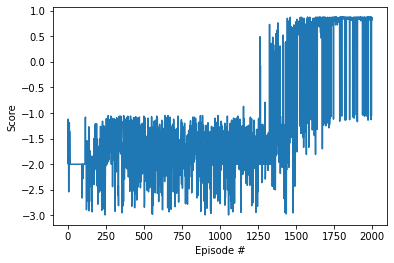

In [283]:
import matplotlib.pyplot as plt


def dqn(n_episodes=2000, max_t=200):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    indexes_of_holes = get_index_of_holes(env)
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    #eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.choose_action(state)
            next_state, reward, done, _ = take_action(action, env, indexes_of_holes)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        """if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break"""
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [284]:
for i in range(3):
    print("i = {}".format(i))
    state = env.reset()
    done = False

    while not done:
            agent_out = agent.qnetwork_local(torch.tensor(state)).detach()
            index_max = np.argmax(agent_out)
            action =  index_max.item()    
            env.render()
            state, reward, done, _ = env.step(action)

    env.render()
env.close()


i = 0

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFF

In [ ]:
# *********** SOME TESTS *****************************************

In [215]:
action = agent.choose_action(state)
print(action)

2


In [216]:
# https://www.geeksforgeeks.org/namedtuple-in-python/
# Declaring namedtuple()  
Experience = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])

# Adding values  
E = Experience(2,3,-1,5,False)  
      
# Access using index  
print ("The state of E is {}".format(E.state))
print ("The action of E is {}".format(E.action))
print ("The reward of E is {}".format(E.reward))
print ("The next state of E is {}".format(E.next_state))
print ("The done of E is {}".format(E.done))


The state of E is 2
The action of E is 3
The reward of E is -1
The next state of E is 5
The done of E is False


In [217]:
# numpy vstack : Stack arrays in sequence vertically (row wise).
# https://scipython.com/book/chapter-6-numpy/examples/vstack-and-hstack/
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.vstack((a,b))

array([[1, 2, 3],
       [4, 5, 6]])

In [218]:

ACTION_SIZE = 4
BUFFER_SIZE = 1000
BATCH_SIZE = 5

buffer = ReplayBuffer(ACTION_SIZE, BUFFER_SIZE, BATCH_SIZE)

states = [0, 1, 2, 3, 4, 5, 6, 7, 8 , 9 , 10, 11, 12, 13, 14, 15]
actions = [0, 1, 2, 3, 0, 2, 1, 3, 0 , 0 , 1, 1, 2, 3, 3, 1]
rewards = [0, 1, 2, 3, 4, 5, 6, 7, 8 , 9 , 10, 11, 12, 13, 14, 15]
next_states = [0, 1, 2, 3, 4, 5, 6, 7, 8 , 9 , 10, 11, 12, 13, 14, 15]
dones = [False, False, False, False, False, False, False, False, False, False,False, False, False, False, False,False]
for i in range(16):
    buffer.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

In [219]:
s, a, r, ns, d = buffer.sample()
print(s)
print(a)
print(r)
print(ns)
print(d)

tensor([[ 0.],
        [14.],
        [13.],
        [ 8.],
        [11.]])
tensor([[0],
        [3],
        [3],
        [0],
        [1]])
tensor([[ 0.],
        [14.],
        [13.],
        [ 8.],
        [11.]])
tensor([[ 0.],
        [14.],
        [13.],
        [ 8.],
        [11.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [220]:
state = torch.tensor(2).long().unsqueeze(0)
print(state)

tensor([2])


In [221]:
state = env.reset()
print(state)
action = agent.choose_action(state)
print(action)

0
2


In [222]:
print(ns)
F.one_hot(ns.long(), num_classes=16).squeeze()

tensor([[ 0.],
        [14.],
        [13.],
        [ 8.],
        [11.]])


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [223]:
print(np.arange(4))

random.choice(np.arange(4))

[0 1 2 3]


2

In [224]:
s, a, r, ns, d = buffer.sample()
print(s)
print(a)
print(r)
print(ns)
print(d)

tensor([[ 0.],
        [ 9.],
        [11.],
        [15.],
        [ 3.]])
tensor([[0],
        [0],
        [1],
        [1],
        [3]])
tensor([[ 0.],
        [ 9.],
        [11.],
        [15.],
        [ 3.]])
tensor([[ 0.],
        [ 9.],
        [11.],
        [15.],
        [ 3.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [225]:
print("ns = {}".format(ns))
values = agent.qnetwork_target(ns).detach()
print("values = {}".format(values))
vals, row_idx = values.max(1)
print("vals = {}, row_idx = {}".format(vals, row_idx))

max_values_per_lines = values.max(1)[0]
print("max_values_per_lines = {}".format(max_values_per_lines))

print(max_values_per_lines.unsqueeze(1))


ns = tensor([[ 0.],
        [ 9.],
        [11.],
        [15.],
        [ 3.]])
values = tensor([[ 0.8663,  0.8960,  0.8958,  0.8663],
        [ 0.9194,  0.9604,  0.9603, -0.9999],
        [ 0.6083,  0.8229,  0.6270,  0.9469],
        [ 0.5293,  0.6252,  0.2518,  0.4082],
        [ 0.9195, -1.0003,  0.8959,  0.8959]])
vals = tensor([0.8960, 0.9604, 0.9469, 0.6252, 0.9195]), row_idx = tensor([1, 1, 3, 1, 0])
max_values_per_lines = tensor([0.8960, 0.9604, 0.9469, 0.6252, 0.9195])
tensor([[0.8960],
        [0.9604],
        [0.9469],
        [0.6252],
        [0.9195]])


In [227]:
local_values =  agent.qnetwork_local(ns)
print("local_values = {}".format(local_values))
print("actions = {}".format(a))
local_values.gather(1,a)


local_values = tensor([[ 0.8772,  0.8981,  0.9028,  0.8818],
        [ 0.9197,  0.9622,  0.9671, -1.0005],
        [ 0.6118,  0.8234,  0.6293,  0.9541],
        [ 0.5296,  0.6284,  0.2552,  0.4142],
        [ 0.9193, -1.0011,  0.9063,  0.9066]], grad_fn=<AddmmBackward>)
actions = tensor([[0],
        [0],
        [1],
        [1],
        [3]])


tensor([[0.8772],
        [0.9197],
        [0.8234],
        [0.6284],
        [0.9066]], grad_fn=<GatherBackward>)

In [6]:
np.random.rand(1)

array([0.06460524])

In [8]:
np.arange(4)

array([0, 1, 2, 3])

In [13]:
random.choice(np.arange(4))

1